In [1]:
from pyspark.sql import SparkSession

In [2]:
spark: SparkSession = SparkSession.builder.master('local[*]').getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/10/02 17:44:21 WARN Utils: Your hostname, lev-adauto resolves to a loopback address: 127.0.1.1; using 172.30.176.9 instead (on interface eth0)
23/10/02 17:44:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/02 17:44:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Import and Processing of data

In [3]:
data = spark.read.csv('./data/imdb-reviews-pt-br.csv', header=True, escape='\"', inferSchema=True)

In [4]:
print(f'Número de linhas: {data.count()} | Número de colunas: {len(data.columns)}')

Número de linhas: 49459 | Número de colunas: 4


In [5]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [6]:
data.show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [7]:
data.filter(data.id == 190).select('text_pt').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                          

In [8]:
data.filter(data.id == 12427).select('text_pt').show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                                                                                                                                                                        

In [9]:
data.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



# WordCloud

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [11]:
sample = data.select('text_pt').sample(fraction=0.1, seed=101)

In [12]:
all = [text['text_pt'] for text in sample.collect()]

In [13]:
wordcloud = WordCloud(
  background_color='white',
  width=1920,
  height=1080,
  collocations=False,
  prefer_horizontal=1
).generate(str(all))

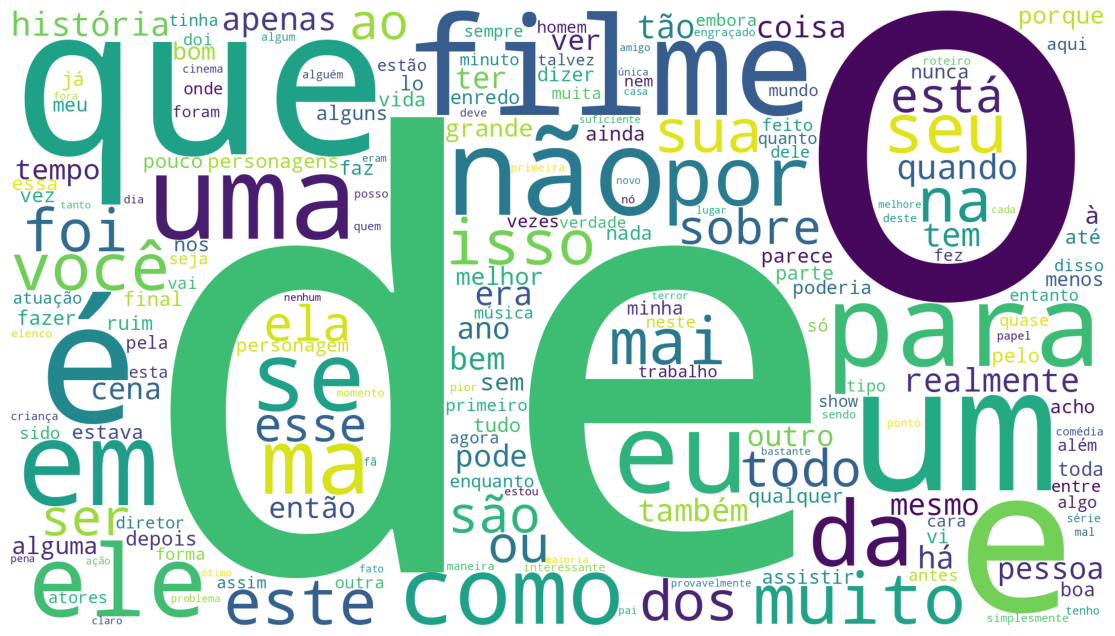

In [14]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Limpeza

In [15]:
import string

In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
sample = spark.createDataFrame(
  [
    ("Oi, JP! Blz?",),
    ("$$$\\ |~ Parabéns ~| \\$$$",),
    ("(#amovc #paz&amor ^.^)",),
    ("\"bora *_* \"",),
    ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
    ("{comprar: arroz; feijão e pepino} //",),
    ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
    ("ana@gmail.com",)
  ],
  ["texts"]
)

In [18]:
import pyspark.sql.functions as f

In [19]:
sample = sample.withColumn('text_regex', f.regexp_replace('texts', '[\$#,\"!%&\'()*+-./;:<=>?@^_`´{|}~\\\\]', ''))

In [20]:
sample = sample.withColumn('clean_text', f.trim('text_regex'))

In [21]:
sample.show(truncate=False)

+------------------------------------------+------------------------------+-----------------------------+
|texts                                     |text_regex                    |clean_text                   |
+------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |amovc pazamor                |
|"bora *_* "                               |bora                          |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]

In [22]:
data = data.withColumn('text_en_regex', f.regexp_replace('text_en', '[\$#,\"!%&\'()*+-./;:<=>?@^_`´{|}~\\\\]', ''))
data = data.withColumn('text_pt_regex', f.regexp_replace('text_pt', '[\$#,\"!%&\'()*+-./;:<=>?@^_`´{|}~\\\\]', ''))

In [23]:
data = data.withColumn('clean_text_en', f.trim('text_en_regex'))
data = data.withColumn('clean_text_pt', f.trim('text_pt_regex'))

In [24]:
data.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Tokenização

In [25]:
from pyspark.ml.feature import Tokenizer

In [26]:
tokenizer = Tokenizer(inputCol='clean_text_pt', outputCol='tokens')

In [27]:
tokenized = tokenizer.transform(data)

In [28]:
tokenized.select('clean_text_pt', 'tokens').show()

+--------------------+--------------------+
|       clean_text_pt|              tokens|
+--------------------+--------------------+
|Mais uma vez o Sr...|[mais, uma, vez, ...|
|Este é um exemplo...|[este, é, um, exe...|
|Primeiro de tudo ...|[primeiro, de, tu...|
|Nem mesmo os Beat...|[nem, mesmo, os, ...|
|Filmes de fotos d...|[filmes, de, foto...|
|Uma coisa engraça...|[uma, coisa, engr...|
|Este filme de ter...|[este, filme, de,...|
|Sendo um fã de lo...|[sendo, um, fã, d...|
|Tokyo Eyes fala d...|[tokyo, eyes, fal...|
|Fazendeiros ricos...|[fazendeiros, ric...|
|Cage interpreta u...|[cage, interpreta...|
|Primeiro de tudo ...|[primeiro, de, tu...|
|Então me diga  qu...|[então, me, diga,...|
|Uma grande decepç...|[uma, grande, dec...|
|Este filme é abso...|[este, filme, é, ...|
|Heres um decidida...|[heres, um, decid...|
|Na parte inferior...|[na, parte, infer...|
|A terra foi destr...|[a, terra, foi, d...|
|Muitas pessoas es...|[muitas, pessoas,...|
|A família de Nova...|[a, famíli

In [29]:
from pyspark.sql.types import IntegerType

countTokens = f.udf(lambda tokens: len(tokens), IntegerType())

tokenized \
  .select('clean_text_pt', 'tokens') \
  .withColumn('freq_tokens', countTokens(f.col('tokens'))) \
  .show()

+--------------------+--------------------+-----------+
|       clean_text_pt|              tokens|freq_tokens|
+--------------------+--------------------+-----------+
|Mais uma vez o Sr...|[mais, uma, vez, ...|        168|
|Este é um exemplo...|[este, é, um, exe...|        245|
|Primeiro de tudo ...|[primeiro, de, tu...|        213|
|Nem mesmo os Beat...|[nem, mesmo, os, ...|        324|
|Filmes de fotos d...|[filmes, de, foto...|        244|
|Uma coisa engraça...|[uma, coisa, engr...|        116|
|Este filme de ter...|[este, filme, de,...|        161|
|Sendo um fã de lo...|[sendo, um, fã, d...|        146|
|Tokyo Eyes fala d...|[tokyo, eyes, fal...|        130|
|Fazendeiros ricos...|[fazendeiros, ric...|        167|
|Cage interpreta u...|[cage, interpreta...|        106|
|Primeiro de tudo ...|[primeiro, de, tu...|        315|
|Então me diga  qu...|[então, me, diga,...|        247|
|Uma grande decepç...|[uma, grande, dec...|        107|
|Este filme é abso...|[este, filme, é, ...|     

# StopWords

In [30]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords
stop_A = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /home/lev-
[nltk_data]     adauto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
from pyspark.ml.feature import StopWordsRemover

In [32]:
remover = StopWordsRemover(inputCol='tokens', outputCol='final_text', stopWords=stop_A)

In [33]:
df = remover.transform(tokenized)

In [34]:
df.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|       text_en_regex|       text_pt_regex|       clean_text_en|       clean_text_pt|              tokens|          final_text|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Mais uma vez o Sr...|Once again Mr Cos...|Mais uma vez o Sr...|[mais, uma, vez, ...|[vez, sr, costner...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|Este é um exemplo...|This is an exampl...|Este é um exemplo...|[este, é, um, exe...|[exemplo, motivo,...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|Pr

In [35]:
df \
  .select('tokens', 'final_text') \
  .withColumn('freq_tokens', countTokens(f.col('tokens'))) \
  .withColumn('freq_clean_tokens', countTokens(f.col('final_text'))) \
  .show()

+--------------------+--------------------+-----------+-----------------+
|              tokens|          final_text|freq_tokens|freq_clean_tokens|
+--------------------+--------------------+-----------+-----------------+
|[mais, uma, vez, ...|[vez, sr, costner...|        168|               79|
|[este, é, um, exe...|[exemplo, motivo,...|        245|              138|
|[primeiro, de, tu...|[primeiro, tudo, ...|        213|              117|
|[nem, mesmo, os, ...|[beatles, puderam...|        324|              167|
|[filmes, de, foto...|[filmes, fotos, l...|        244|              144|
|[uma, coisa, engr...|[coisa, engraçada...|        116|               61|
|[este, filme, de,...|[filme, terror, a...|        161|               75|
|[sendo, um, fã, d...|[sendo, fã, longa...|        146|               75|
|[tokyo, eyes, fal...|[tokyo, eyes, fal...|        130|               77|
|[fazendeiros, ric...|[fazendeiros, ric...|        167|               96|
|[cage, interpreta...|[cage, interpret

# Vetorização

In [36]:
from pyspark.ml.feature import CountVectorizer

In [37]:
cv = CountVectorizer(inputCol='final_text', outputCol='count_vec')

In [38]:
model = cv.fit(df)

In [39]:
count_vectorizer_features = model.transform(df)

In [40]:
count_vectorizer_features.select('final_text', 'count_vec').show(truncate=False)

23/10/02 17:45:00 WARN DAGScheduler: Broadcasting large task binary with size 1873.0 KiB


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [41]:
model.vocabulary

['filme',
 '',
 'filmes',
 'sobre',
 'tão',
 'realmente',
 'apenas',
 'história',
 'bem',
 'todos',
 'pode',
 'ter',
 'então',
 'anos',
 'ver',
 'melhor',
 'pessoas',
 'bom',
 'porque',
 'tempo',
 'ainda',
 'qualquer',
 'tudo',
 'vez',
 'pouco',
 'fazer',
 'personagens',
 'grande',
 'alguns',
 'final',
 'parece',
 'vida',
 'the',
 'nunca',
 'faz',
 'vi',
 'coisa',
 'dizer',
 'nada',
 'assistir',
 'todo',
 'poderia',
 'algumas',
 'menos',
 'parte',
 'enredo',
 'ruim',
 'cenas',
 'acho',
 'personagem',
 'enquanto',
 'embora',
 'outros',
 'aqui',
 'vezes',
 'sido',
 'cena',
 'assim',
 'atuação',
 'outro',
 'vai',
 'onde',
 'algo',
 'neste',
 'dois',
 'quanto',
 'disso',
 'trabalho',
 'atores',
 'coisas',
 'sempre',
 'agora',
 'forma',
 'feito',
 'antes',
 'fez',
 'boa',
 'homem',
 'quase',
 'entanto',
 'primeiro',
 'mundo',
 'muitos',
 'diretor',
 'além',
 'verdade',
 'talvez',
 'tipo',
 'alguém',
 'muitas',
 'show',
 'deve',
 'simplesmente',
 'elenco',
 'algum',
 'papel',
 'cinema',
 'mú

# Hasing TF

Alternativa ao Count Vector

In [42]:
from pyspark.ml.feature import HashingTF

In [43]:
hashing_tf = HashingTF(inputCol='final_text', outputCol='hashing_tf')

In [44]:
hashing_tf.setNumFeatures(50)

HashingTF_a66e9a7c8355

In [45]:
htf_featurezed_data = hashing_tf.transform(count_vectorizer_features)

In [46]:
htf_featurezed_data.select('final_text', 'hashing_tf').show()

+--------------------+--------------------+
|          final_text|          hashing_tf|
+--------------------+--------------------+
|[vez, sr, costner...|(50,[1,3,4,5,7,9,...|
|[exemplo, motivo,...|(50,[0,2,4,5,6,7,...|
|[primeiro, tudo, ...|(50,[0,1,2,3,4,5,...|
|[beatles, puderam...|(50,[1,3,4,5,6,7,...|
|[filmes, fotos, l...|(50,[2,3,4,5,6,7,...|
|[coisa, engraçada...|(50,[1,2,3,4,5,6,...|
|[filme, terror, a...|(50,[0,2,3,4,5,6,...|
|[sendo, fã, longa...|(50,[0,1,2,3,4,6,...|
|[tokyo, eyes, fal...|(50,[0,1,3,4,5,6,...|
|[fazendeiros, ric...|(50,[0,1,3,4,5,6,...|
|[cage, interpreta...|(50,[0,1,2,4,7,9,...|
|[primeiro, tudo, ...|(50,[0,1,2,3,4,5,...|
|[então, diga, , b...|(50,[0,1,2,3,4,5,...|
|[grande, decepção...|(50,[0,2,4,5,7,9,...|
|[filme, absolutam...|(50,[3,4,5,6,7,8,...|
|[heres, decididam...|(50,[0,1,3,4,5,6,...|
|[parte, inferior,...|(50,[0,1,3,4,5,7,...|
|[terra, destruída...|(50,[1,2,3,4,5,6,...|
|[muitas, pessoas,...|(50,[0,1,2,3,4,5,...|
|[família, nova, y...|(50,[1,3,5

# TF-IDF

Estabelecendo pesos

In [47]:
from pyspark.ml.feature import IDF

In [48]:
idf = IDF(inputCol='hashing_tf', outputCol='features')

In [49]:
idf_model = idf.fit(htf_featurezed_data)

In [50]:
tf_idf_featurized_data = idf_model.transform(htf_featurezed_data)

In [51]:
tf_idf_featurized_data.select('final_text', 'features').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Codificando

Variável e resposta

In [52]:
tf_idf_featurized_data.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [53]:
from pyspark.ml.feature import StringIndexer

In [54]:
stringindexes = StringIndexer(inputCol='sentiment', outputCol='label')

In [55]:
data = stringindexes.fit(data).transform(data)

In [56]:
data.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+-----+
| id|             text_en|             text_pt|sentiment|       text_en_regex|       text_pt_regex|       clean_text_en|       clean_text_pt|label|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+-----+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Mais uma vez o Sr...|Once again Mr Cos...|Mais uma vez o Sr...|  0.0|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|Este é um exemplo...|This is an exampl...|Este é um exemplo...|  0.0|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|Primeiro de tudo ...|First of all I ha...|Primeiro de tudo ...|  0.0|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Nem mesmo os Beat...|Not even the 

In [57]:
data.groupBy('sentiment', 'label').count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



# Pipeline

Transformação dos dados

In [58]:
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol = "clean_text_pt", outputCol = "tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="final_text")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="htf", numFeatures=1000)
tfidf = IDF(inputCol="htf", outputCol="features")

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

In [59]:
transform_data = pipeline.fit(data).transform(data)

In [61]:
transform_data.show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Model

In [62]:
feature_df = transform_data.select('features', 'label')

In [63]:
feature_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [64]:
feature_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1000,[8,14,16,22...|  0.0|
|(1000,[10,17,24,3...|  0.0|
|(1000,[5,8,9,24,3...|  0.0|
|(1000,[1,9,24,30,...|  0.0|
|(1000,[7,9,12,24,...|  0.0|
|(1000,[9,65,67,76...|  0.0|
|(1000,[2,3,7,9,10...|  0.0|
|(1000,[15,16,19,2...|  0.0|
|(1000,[0,35,64,66...|  0.0|
|(1000,[10,19,30,4...|  0.0|
|(1000,[2,29,61,66...|  0.0|
|(1000,[3,8,9,15,1...|  0.0|
|(1000,[3,9,10,12,...|  0.0|
|(1000,[8,24,29,50...|  0.0|
|(1000,[1,32,37,61...|  0.0|
|(1000,[8,11,16,24...|  0.0|
|(1000,[7,15,24,28...|  0.0|
|(1000,[2,24,30,32...|  0.0|
|(1000,[1,7,16,24,...|  0.0|
|(1000,[10,30,37,3...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol = "clean_text_pt", outputCol = "tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="final_text")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="htf", numFeatures=1000)
tfidf = IDF(inputCol="htf", outputCol="features")
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])